# PRJEB65603 - Rasmussen et al.

Article (preprint) link: https://www.eurosurveillance.org/content/10.2807/1560-7917.ES.2023.28.36.2300460

In [1]:
suppressPackageStartupMessages({
    library(provoc)
    library(here)
    library(ggplot2)
    library(lubridate)
    library(dplyr)
    library(geodata)
    library(terra)
    library(tidyterra)
})


In [2]:
coco <- read.csv(
    here("data", "processed", 
        "PRJEB65603_processed.csv.gz")
)
coco$mutation <- parse_mutations(coco$label)
head(coco)


,position,label,mutation,frequency,coverage,count,sra,date,sample_name,avg_spot_len,bases,bioproject,location,lat,lon
,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,1026,+1027.T,ins:1027:1,0,810,0,ERR11967134,2023-08-15,SAMEA114317222,NA,NA,PRJEB65603,Avedre,55.60864,12.45051
2,11074,+11075.T,ins:11075:1,0,0,0,ERR11967134,2023-08-15,SAMEA114317222,NA,NA,PRJEB65603,Avedre,55.60864,12.45051
3,11653,+11654.T,ins:11654:1,0,194,0,ERR11967134,2023-08-15,SAMEA114317222,NA,NA,PRJEB65603,Avedre,55.60864,12.45051
4,15672,+15673.T,ins:15673:1,0,780,0,ERR11967134,2023-08-15,SAMEA114317222,NA,NA,PRJEB65603,Avedre,55.60864,12.45051
5,18907,+18908.T,ins:18908:1,0,5488,0,ERR11967134,2023-08-15,SAMEA114317222,NA,NA,PRJEB65603,Avedre,55.60864,12.45051
6,19164,+19165.A,ins:19165:1,0,378,0,ERR11967134,2023-08-15,SAMEA114317222,NA,NA,PRJEB65603,Avedre,55.60864,12.45051


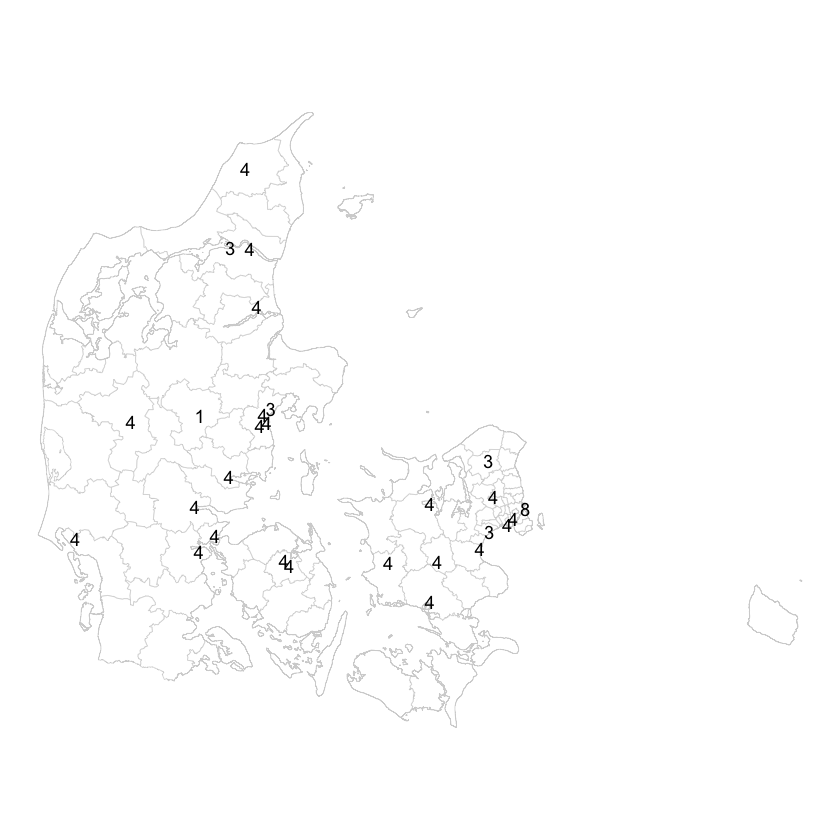

In [3]:
denmark <- gadm(country = "Denmark", level = 2, path = ".")
locs <- coco %>%
    select(sra, lat, lon) %>%
    distinct() %>%
    group_by(lat, lon) %>%
    tally(name = "count")

ggplot() +
    theme_void() +
    geom_spatvector(data = denmark, colour = "lightgrey", fill = "white") +
    geom_text(data = locs, mapping = aes(x = lon, y = lat, label = count))


In [4]:
range(ymd(coco$date))


[1] "2023-08-08" "2023-08-17"

The paper is focused on the detection of BA.2.86 in wastewater. I used the dashboard from the [Danish Covid-19 Genome Consortium](https://www.covid19genomics.dk/statistics), selecting the reports from August and September 2023, to determine the relevant lineages. 

In [5]:
lineages_in_paper <- c("BA.2.86", "XBB.1.16", "XBB.1.5", "XBB.1.9.1", "XBB.1.5.59", "EG.5.1", "EG.5.2", "GE.1")
barcodes <- provoc::usher_barcodes()
available_lineages <- intersect(lineages_in_paper, rownames(barcodes))
barcodes <- filter_lineages(barcodes, available_lineages)
rownames(barcodes)


[1] "BA.2.86"    "EG.5.2"     "EG.5.1"     "XBB.1.16"   "GE.1"      
[6] "XBB.1.9.1"  "XBB.1.5.59" "XBB.1.5"

In [6]:
system.time(
    res <- provoc(count / coverage ~ .,
        data = coco,
        lineage_defs = barcodes,
        by = "sra")
)
head(res)


   user  system elapsed 
 22.668   0.183  23.239 

,rho,ci_low,ci_high,lineage,sra,date,sample_name,avg_spot_len,bases,bioproject,location,lat,lon
,<dbl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,3.767340e-03,NA,NA,BA.2.86,ERR11967134,2023-08-15,SAMEA114317222,NA,NA,PRJEB65603,Avedre,55.60864,12.45051
2,1.242031e-07,NA,NA,EG.5.2,ERR11967134,2023-08-15,SAMEA114317222,NA,NA,PRJEB65603,Avedre,55.60864,12.45051
3,3.854985e-01,NA,NA,EG.5.1,ERR11967134,2023-08-15,SAMEA114317222,NA,NA,PRJEB65603,Avedre,55.60864,12.45051
4,3.680301e-02,NA,NA,XBB.1.16,ERR11967134,2023-08-15,SAMEA114317222,NA,NA,PRJEB65603,Avedre,55.60864,12.45051
5,7.017734e-02,NA,NA,GE.1,ERR11967134,2023-08-15,SAMEA114317222,NA,NA,PRJEB65603,Avedre,55.60864,12.45051
6,3.076736e-01,NA,NA,XBB.1.9.1,ERR11967134,2023-08-15,SAMEA114317222,NA,NA,PRJEB65603,Avedre,55.60864,12.45051


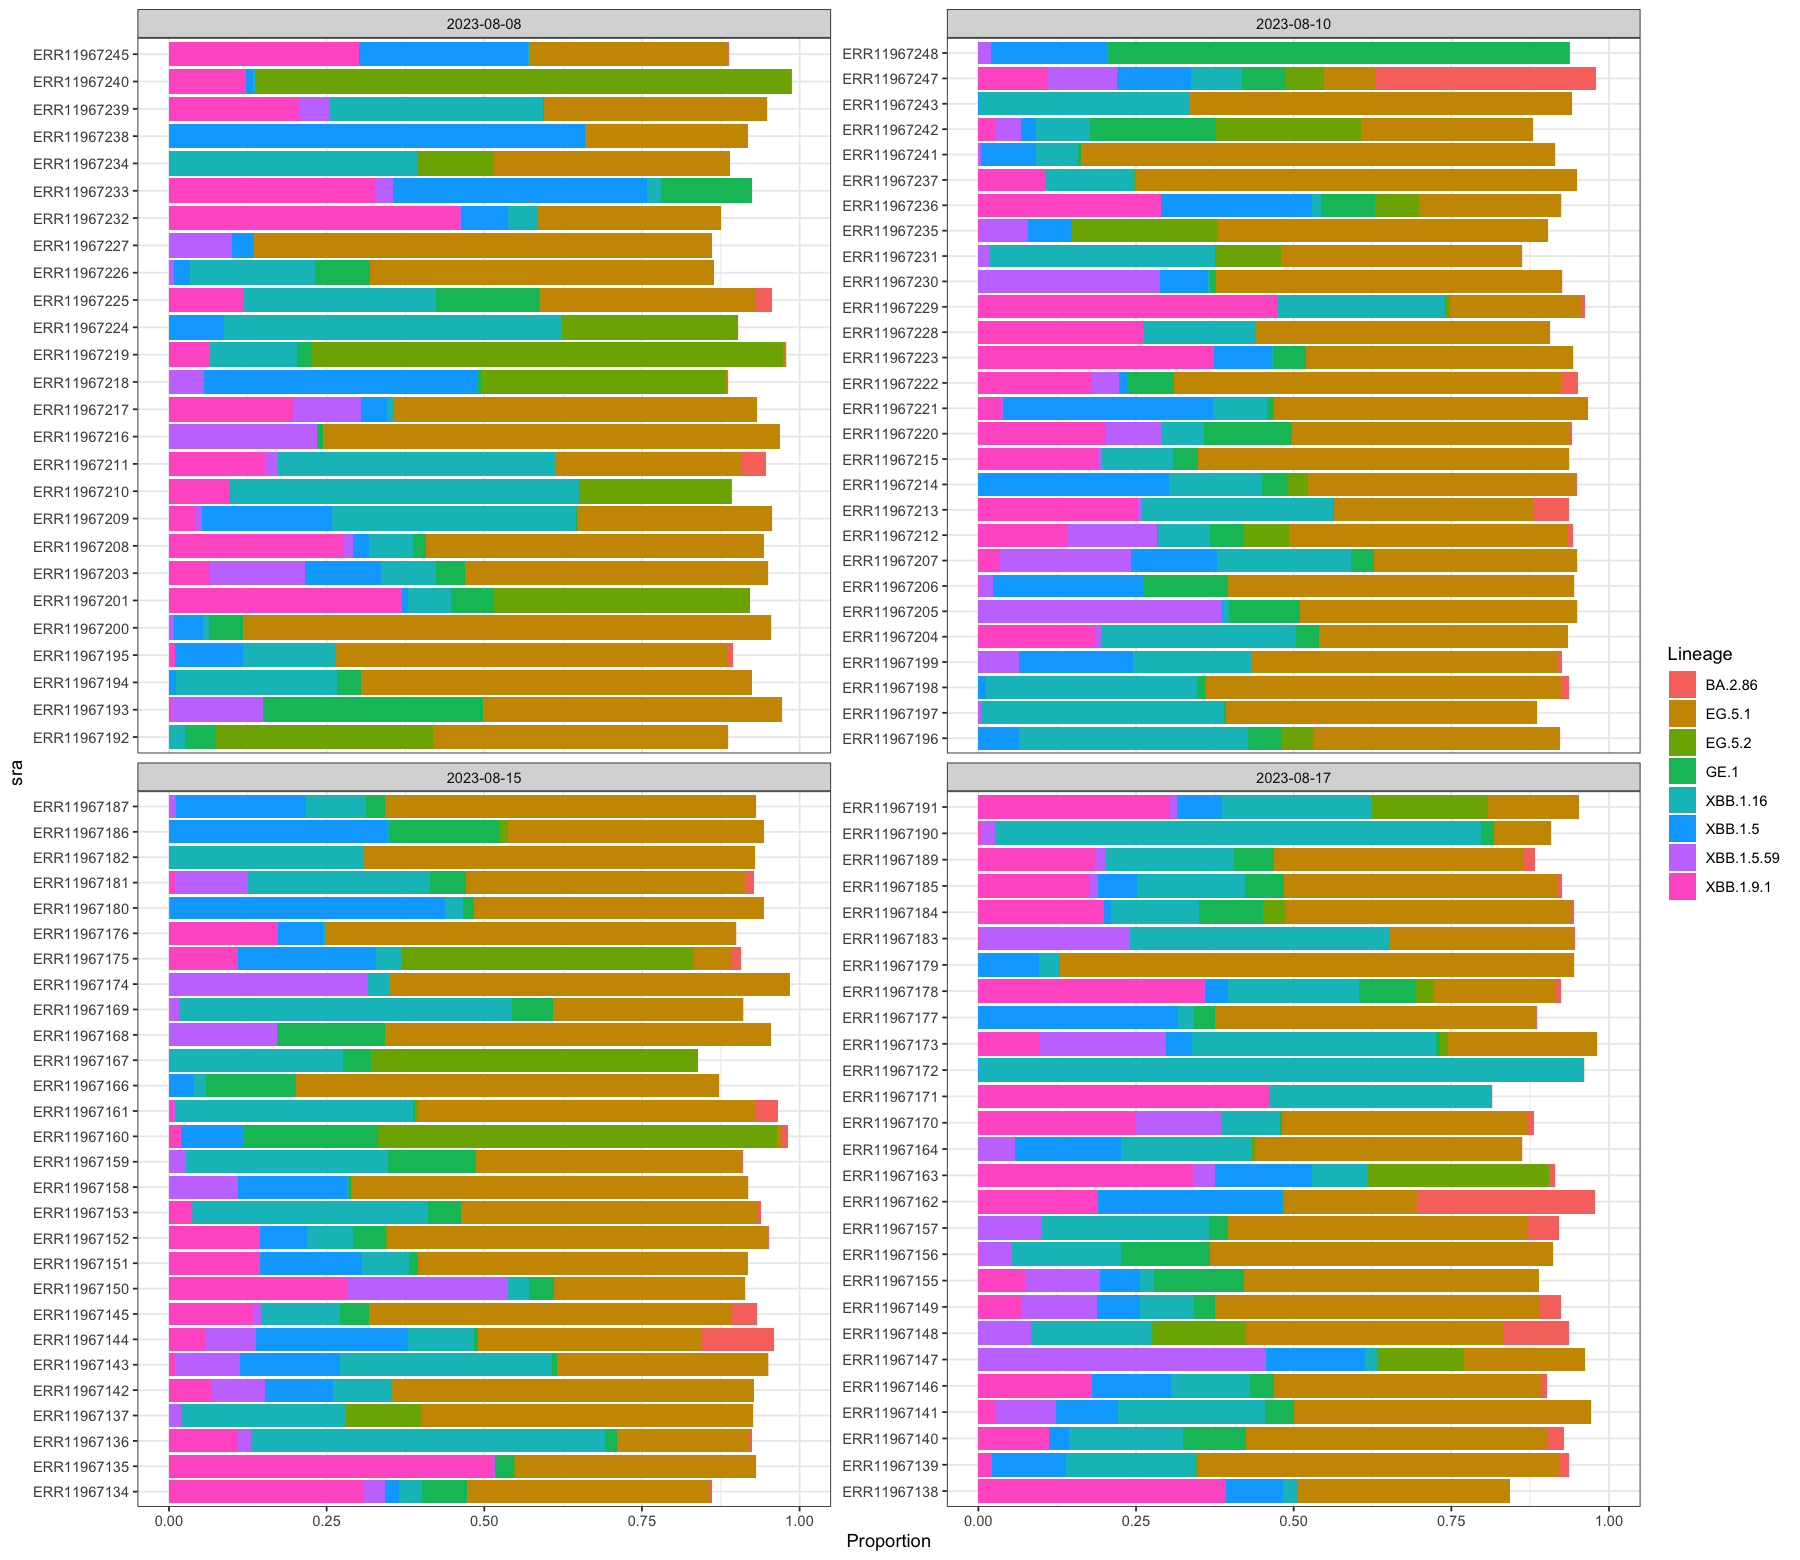

In [7]:
options(repr.plot.width = 15, repr.plot.height = 13)

res$date <- lubridate::ymd(res$date)

gg <- autoplot(res) +
    facet_wrap(~ date, scales = "free_y") +
    theme_bw()
suppressWarnings(print(gg))
